# 1. 환경 설정

In [2]:
import pickle
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [6]:
with open('df_scaled.pickle','rb') as f:
    df_scaled = pickle.load(f)
with open('sector.pickle','rb') as f:
    sector = pickle.load(f)

In [3]:
df_scaled['Food']

,종가,등락률,거래변동량,코스피지수_증감량
일자,,,,
2010-05-14,0.074920,0.491660,0.000000,0.511587
2010-05-17,0.077067,0.468725,0.025468,0.342590
2010-05-18,0.101557,0.554667,0.041343,0.479910
2010-05-19,0.087859,0.434181,0.027336,0.461179
2010-05-20,0.089447,0.486699,0.028428,0.397058
...,...,...,...,...
2022-07-06,0.417075,0.499675,0.023779,0.320948
2022-07-07,0.417794,0.515987,0.040026,0.673459
2022-07-08,0.410821,0.472507,0.022978,0.574176


# 2. train / test 분할

In [14]:
from sklearn.model_selection import train_test_split
X_train_dic = {}
X_test_dic={}
y_train_dic = {}
y_test_dic = {}
#모델이 각 업종마다 존재한다. 18개
for sector_name, df in df_scaled.items():
    # 단 셔플 없이 분할
    X_train, X_test, y_train, y_test = train_test_split(df.drop('종가', 1), df['종가'], test_size=0.2, random_state=0, shuffle=False)
    X_train_dic[sector_name] = X_train
    X_test_dic[sector_name] = X_test
    y_train_dic[sector_name] = y_train
    y_test_dic[sector_name] = y_test
    
    

In [5]:
X_train_dic['Food'].shape, y_train_dic['Food'].shape

((2400, 3), (2400,))

In [6]:
X_test_dic['Food'].shape, y_test_dic['Food'].shape

((600, 3), (600,))

In [7]:
X_test_dic['Food']

,등락률,거래변동량,코스피지수_증감량
일자,,,
2020-02-10,0.486302,0.090778,0.469912
2020-02-11,0.582165,0.069031,0.596047
2020-02-12,0.623230,0.022802,0.570039
2020-02-13,0.510580,0.047191,0.490826
2020-02-14,0.470111,0.069654,0.552304
...,...,...,...
2022-07-06,0.499675,0.023779,0.320948
2022-07-07,0.515987,0.040026,0.673459
2022-07-08,0.472507,0.022978,0.574176


In [8]:
y_test_dic['Food']

일자
2020-02-10    0.142622
2020-02-11    0.168579
2020-02-12    0.198409
2020-02-13    0.207431
2020-02-14    0.204221
                ...   
2022-07-06    0.417075
2022-07-07    0.417794
2022-07-08    0.410821
2022-07-11    0.406615
2022-07-12    0.415415
Name: 종가, Length: 600, dtype: float64

## feature갯수가 여러개인 경우

In [9]:
pd.concat([X_train_dic['Food'],y_train_dic['Food']],axis=1).head(10)

,등락률,거래변동량,코스피지수_증감량,종가
일자,,,,
2010-05-14,0.491660,0.000000,0.511587,0.074920
2010-05-17,0.468725,0.025468,0.342590,0.077067
2010-05-18,0.554667,0.041343,0.479910,0.101557
2010-05-19,0.434181,0.027336,0.461179,0.087859
2010-05-20,0.486699,0.028428,0.397058,0.089447
2010-05-24,0.469816,0.010051,0.529781,0.085020
2010-05-25,0.420716,0.021355,0.342667,0.076165
2010-05-26,0.563036,0.007036,0.593136,0.085369
2010-05-27,0.508064,0.043104,0.608802,0.084190


# 3. TensorFlow Dataset을 활용한 시퀀스 데이터셋 구성(X데이터, y데이터 각각 구성)
## 다중스텝 예측

## 예시사진

<img src="https://blog.kakaocdn.net/dn/yugzK/btrkweR5DyK/kB4xmJOr8GzTAbq614RF1k/img.png" alt="img" style="zoom: 50%;" />

In [15]:
import tensorflow as tf

In [16]:
# 윈도우 데이터셋 생성 함수
def windowed_dataset(X, y, X_size, y_size, X_shift, y_shift, X_stride, y_stride, batch_size):
    
    # numpy array x(input)를 Dataset으로 변환
    ds_x = tf.data.Dataset.from_tensor_slices(X)
    
    #윈도우셋 구성
    ds_x = ds_x.window(size=X_size,stride=X_stride, shift=X_shift, drop_remainder=True)
    #한 차원 줄야사 반환
    ds_x = ds_x.flat_map(lambda x: x.batch(X_size))
    
    ds_y = tf.data.Dataset.from_tensor_slices(y)
    ds_y = ds_y.window(size=y_size, stride=y_stride, shift=y_shift, drop_remainder=True)
    ds_y = ds_y.flat_map(lambda y: y.batch(y_size))
    
    #같은 인덱스에 있는 애들 끼리 묶기
    ds = tf.data.Dataset.zip((ds_x, ds_y))
    
    return ds.batch(batch_size).prefetch(1)

## Hyperparameter를 정의합니다.

In [8]:
#윈도우 사이즈
WINDOW_SIZE = 10
# X에 대한 윈도우 함수 설정값
X_size = WINDOW_SIZE
X_shift = 10
X_stride = 1
# y에 대한 윈도우 함수 설정값
y_size = 1
y_shift = WINDOW_SIZE
y_stride = 1

batch_size = 1

In [17]:
tf_dataset_train_dic={}
for sector_name, X_train in X_train_dic.items():
    y_train = y_train_dic[sector_name]
    tf_dataset_train_dic[sector_name] = windowed_dataset(X_train,y_train[WINDOW_SIZE:], X_size, y_size,
                                X_shift, y_shift, X_stride, y_stride, batch_size)

tf_dataset_test_dic = {}
for sector_name, X_test in X_test_dic.items():
    y_test = y_test_dic[sector_name]
    tf_dataset_test_dic[sector_name] = windowed_dataset(X_test,y_test[WINDOW_SIZE:], X_size, y_size,
                                X_shift, y_shift, X_stride, y_stride, batch_size)

    # 데이터 shape, 미리보기로 체크
for x, y in tf_dataset_train_dic['Food'].take(3):
    print('X:', x.shape)
    print(x)
    print()
    print('Y:', y.shape)
    print(y)
    print('-'*100)

X: (1, 10, 3)
tf.Tensor(
[[[0.49165988 0.         0.51158693]
  [0.46872454 0.02546783 0.34259011]
  [0.55466659 0.04134298 0.4799096 ]
  [0.43418092 0.027336   0.46117899]
  [0.48669945 0.02842761 0.39705826]
  [0.46981555 0.01005135 0.52978128]
  [0.4207155  0.02135518 0.34266672]
  [0.5630358  0.00703604 0.59313594]
  [0.50806373 0.0431039  0.60880224]
  [0.47114415 0.03970557 0.57011529]]], shape=(1, 10, 3), dtype=float64)

Y: (1, 1)
tf.Tensor([[0.08930914]], shape=(1, 1), dtype=float64)
----------------------------------------------------------------------------------------------------
X: (1, 10, 3)
tf.Tensor(
[[[0.56842294 0.0121771  0.58233424]
  [0.49388068 0.00575102 0.4700272 ]
  [0.52007448 0.02070692 0.6320144 ]
  [0.43344874 0.02260477 0.52035852]
  [0.45652469 0.01228435 0.41138392]
  [0.48210753 0.0109208  0.5633355 ]
  [0.49587358 0.00292051 0.49526947]
  [0.52859886 0.01082026 0.52874708]
  [0.53365627 0.01215604 0.60213736]
  [0.54259766 0.01587706 0.57003869]]], shap

In [13]:
y_train_dic['Food'][20]

0.09138454897142578

## 모델

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [9]:
model_dic ={}
for sector_name in sector.keys():
    model_dic[sector_name] = Sequential([
        # 1차원 feature map 생성
        Conv1D(filters=32, kernel_size=5,
               padding="causal",
               activation="relu",
               #feature의 개수 3개
               input_shape=[WINDOW_SIZE, 3]),
        # LSTM
        LSTM(16, activation='tanh'),
        Dense(16, activation="relu"),
        Dense(1),
    ])

In [16]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
for sector_model in model_dic.values():
    sector_model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])


In [ ]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)

In [11]:
# val_loss 기준 체크포인터도 생성합니다.
filename_dic={}
for sector_name in sector:
    filename_dic[sector_name] = os.path.join('tmp', sector_name+'ckeckpointer.ckpt')

In [18]:
#체크포인트를 저장    
mc_dic = {}
for sector_name in sector:
    mc_dic[sector_name] = ModelCheckpoint(filename_dic[sector_name], 
                         save_weights_only=True, 
                         save_best_only=True, 
                         monitor='val_loss', 
                         verbose=1)

In [19]:
history_dic={}
# 학습+저장
for sector_name, train_data in tf_dataset_train_dic.items():
    test_data = tf_dataset_test_dic[sector_name]
    history = model_dic[sector_name].fit(train_data, 
                        validation_data=(test_data), 
                        epochs=50, 
                        callbacks=[mc_dic[sector_name], earlystopping])
    history_dic[sector_name] = history

Epoch 1/50
239/239 [==============================] - 3s 6ms/step - loss: 0.0048 - mse: 0.0096 - val_loss: 0.0446 - val_mse: 0.0893

Epoch 00001: val_loss improved from inf to 0.04463, saving model to tmp\Foodckeckpointer.ckpt
Epoch 2/50
239/239 [==============================] - 1s 4ms/step - loss: 0.0047 - mse: 0.0094 - val_loss: 0.0318 - val_mse: 0.0636

Epoch 00002: val_loss improved from 0.04463 to 0.03178, saving model to tmp\Foodckeckpointer.ckpt
Epoch 3/50
239/239 [==============================] - 1s 5ms/step - loss: 0.0057 - mse: 0.0113 - val_loss: 0.0225 - val_mse: 0.0451

Epoch 00003: val_loss improved from 0.03178 to 0.02253, saving model to tmp\Foodckeckpointer.ckpt
Epoch 4/50
239/239 [==============================] - 1s 5ms/step - loss: 0.0065 - mse: 0.0129 - val_loss: 0.0253 - val_mse: 0.0506

Epoch 00004: val_loss did not improve from 0.02253
Epoch 5/50
239/239 [==============================] - 1s 4ms/step - loss: 0.0063 - mse: 0.0126 - val_loss: 0.0174 - val_mse: 0.

239/239 [==============================] - 1s 4ms/step - loss: 0.0165 - mse: 0.0329 - val_loss: 0.0053 - val_mse: 0.0106

Epoch 00040: val_loss did not improve from 0.00503
Epoch 41/50
239/239 [==============================] - 1s 4ms/step - loss: 0.0167 - mse: 0.0335 - val_loss: 0.0050 - val_mse: 0.0100

Epoch 00041: val_loss improved from 0.00503 to 0.00502, saving model to tmp\Foodckeckpointer.ckpt
Epoch 42/50
239/239 [==============================] - 1s 4ms/step - loss: 0.0168 - mse: 0.0336 - val_loss: 0.0050 - val_mse: 0.0100

Epoch 00042: val_loss improved from 0.00502 to 0.00502, saving model to tmp\Foodckeckpointer.ckpt
Epoch 43/50
239/239 [==============================] - 1s 5ms/step - loss: 0.0168 - mse: 0.0337 - val_loss: 0.0050 - val_mse: 0.0100

Epoch 00043: val_loss improved from 0.00502 to 0.00501, saving model to tmp\Foodckeckpointer.ckpt
Epoch 44/50
239/239 [==============================] - 1s 4ms/step - loss: 0.0139 - mse: 0.0278 - val_loss: 0.0434 - val_mse: 0.086

239/239 [==============================] - 1s 4ms/step - loss: 0.0069 - mse: 0.0138 - val_loss: 0.0786 - val_mse: 0.1572

Epoch 00004: val_loss did not improve from 0.07773
Epoch 5/50
239/239 [==============================] - 1s 4ms/step - loss: 0.0078 - mse: 0.0155 - val_loss: 0.0948 - val_mse: 0.1895

Epoch 00005: val_loss did not improve from 0.07773
Epoch 6/50
239/239 [==============================] - 1s 4ms/step - loss: 0.0032 - mse: 0.0064 - val_loss: 0.0794 - val_mse: 0.1587

Epoch 00006: val_loss did not improve from 0.07773
Epoch 7/50
239/239 [==============================] - 1s 4ms/step - loss: 0.0047 - mse: 0.0094 - val_loss: 0.0793 - val_mse: 0.1586

Epoch 00007: val_loss did not improve from 0.07773
Epoch 8/50
239/239 [==============================] - 1s 4ms/step - loss: 0.0055 - mse: 0.0111 - val_loss: 0.0838 - val_mse: 0.1676

Epoch 00008: val_loss did not improve from 0.07773
Epoch 9/50
239/239 [==============================] - 1s 4ms/step - loss: 0.0087 - mse: 0.0


Epoch 00013: val_loss improved from 0.00202 to 0.00194, saving model to tmp\Transportckeckpointer.ckpt
Epoch 14/50
239/239 [==============================] - 1s 4ms/step - loss: 0.0336 - mse: 0.0672 - val_loss: 0.0027 - val_mse: 0.0055

Epoch 00014: val_loss did not improve from 0.00194
Epoch 15/50
239/239 [==============================] - 1s 5ms/step - loss: 0.0339 - mse: 0.0677 - val_loss: 0.0041 - val_mse: 0.0083

Epoch 00015: val_loss did not improve from 0.00194
Epoch 16/50
239/239 [==============================] - 1s 4ms/step - loss: 0.0338 - mse: 0.0677 - val_loss: 0.0097 - val_mse: 0.0194

Epoch 00016: val_loss did not improve from 0.00194
Epoch 17/50
239/239 [==============================] - 1s 4ms/step - loss: 0.0226 - mse: 0.0451 - val_loss: 0.0024 - val_mse: 0.0048

Epoch 00017: val_loss did not improve from 0.00194
Epoch 18/50
239/239 [==============================] - 1s 4ms/step - loss: 0.0358 - mse: 0.0715 - val_loss: 0.0017 - val_mse: 0.0034

Epoch 00018: val_loss 

239/239 [==============================] - 1s 4ms/step - loss: 0.0194 - mse: 0.0388 - val_loss: 0.0353 - val_mse: 0.0705

Epoch 00015: val_loss did not improve from 0.03489
Epoch 16/50
239/239 [==============================] - 1s 5ms/step - loss: 0.0181 - mse: 0.0362 - val_loss: 0.0677 - val_mse: 0.1354

Epoch 00016: val_loss did not improve from 0.03489
Epoch 17/50
239/239 [==============================] - 1s 5ms/step - loss: 0.0077 - mse: 0.0153 - val_loss: 0.0349 - val_mse: 0.0699

Epoch 00017: val_loss did not improve from 0.03489
Epoch 18/50
239/239 [==============================] - 1s 4ms/step - loss: 0.0113 - mse: 0.0225 - val_loss: 0.0349 - val_mse: 0.0698

Epoch 00018: val_loss did not improve from 0.03489
Epoch 19/50
239/239 [==============================] - 1s 4ms/step - loss: 0.0197 - mse: 0.0393 - val_loss: 0.0349 - val_mse: 0.0699

Epoch 00019: val_loss did not improve from 0.03489
Epoch 20/50
239/239 [==============================] - 1s 4ms/step - loss: 0.0198 - mse

239/239 [==============================] - 1s 4ms/step - loss: 0.0064 - mse: 0.0127 - val_loss: 0.0396 - val_mse: 0.0792

Epoch 00007: val_loss did not improve from 0.02187
Epoch 8/50
239/239 [==============================] - 1s 4ms/step - loss: 0.0066 - mse: 0.0131 - val_loss: 0.0407 - val_mse: 0.0813

Epoch 00008: val_loss did not improve from 0.02187
Epoch 9/50
239/239 [==============================] - 1s 4ms/step - loss: 0.0067 - mse: 0.0135 - val_loss: 0.0415 - val_mse: 0.0830

Epoch 00009: val_loss did not improve from 0.02187
Epoch 10/50
239/239 [==============================] - 1s 4ms/step - loss: 0.0069 - mse: 0.0138 - val_loss: 0.0418 - val_mse: 0.0836

Epoch 00010: val_loss did not improve from 0.02187
Epoch 11/50
239/239 [==============================] - 1s 5ms/step - loss: 0.0064 - mse: 0.0128 - val_loss: 0.0410 - val_mse: 0.0820

Epoch 00011: val_loss did not improve from 0.02187
Epoch 1/50
239/239 [==============================] - 3s 6ms/step - loss: 0.0072 - mse: 0

239/239 [==============================] - 1s 4ms/step - loss: 0.0050 - mse: 0.0100 - val_loss: 0.0461 - val_mse: 0.0923

Epoch 00006: val_loss improved from 0.04713 to 0.04614, saving model to tmp\Serviceckeckpointer.ckpt
Epoch 7/50
239/239 [==============================] - 1s 4ms/step - loss: 0.0065 - mse: 0.0131 - val_loss: 0.0775 - val_mse: 0.1550

Epoch 00007: val_loss did not improve from 0.04614
Epoch 8/50
239/239 [==============================] - 1s 4ms/step - loss: 0.0054 - mse: 0.0107 - val_loss: 0.0461 - val_mse: 0.0922

Epoch 00008: val_loss improved from 0.04614 to 0.04608, saving model to tmp\Serviceckeckpointer.ckpt
Epoch 9/50
239/239 [==============================] - 1s 4ms/step - loss: 0.0058 - mse: 0.0116 - val_loss: 0.0655 - val_mse: 0.1310

Epoch 00009: val_loss did not improve from 0.04608
Epoch 10/50
239/239 [==============================] - 1s 4ms/step - loss: 0.0065 - mse: 0.0130 - val_loss: 0.0732 - val_mse: 0.1464

Epoch 00010: val_loss did not improve fro

In [12]:
load_model_checkpoint={}
for sector_name in sector:
    load_model_checkpoint[sector_name] = model_dic[sector_name].load_weights(filename_dic[sector_name])

# 예측 데이터 시각화
아래 시각화 코드중 y_test 데이터에 [20:]으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 앞의 20일은 예측하지 않습니다.

따라서, 20번 째 index와 비교하면 더욱 정확합니다.

Food의 test_data의 출력 크기 :  (59, 1)


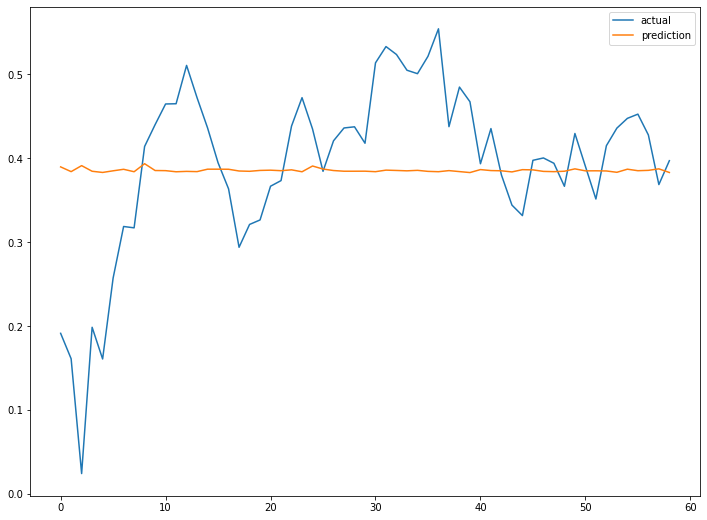

Clothing의 test_data의 출력 크기 :  (59, 1)


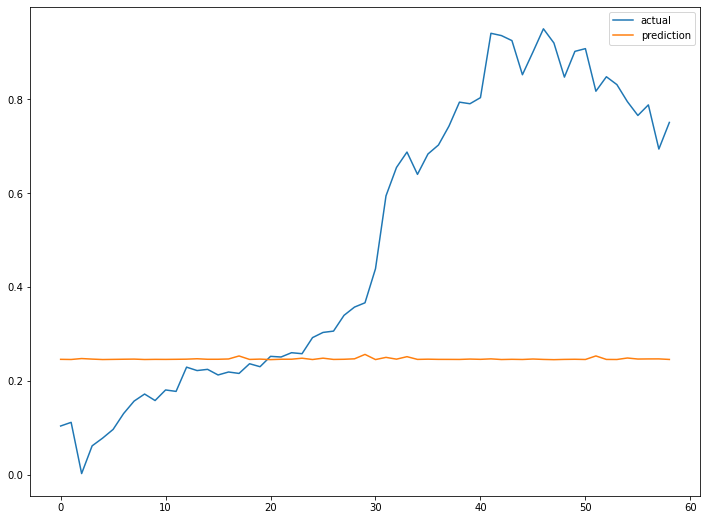

Chemical의 test_data의 출력 크기 :  (59, 1)


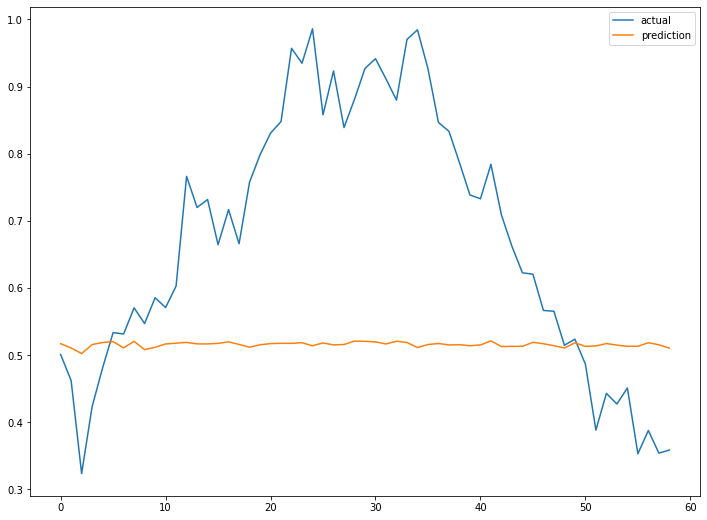

Medicine의 test_data의 출력 크기 :  (59, 1)


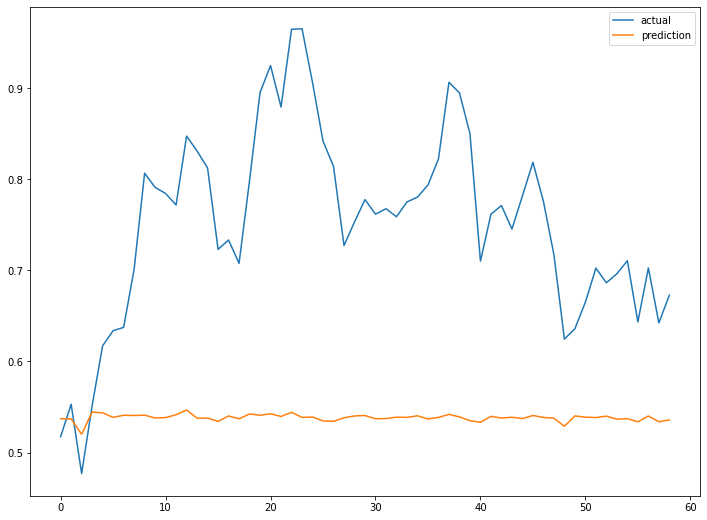

Non_Metal의 test_data의 출력 크기 :  (59, 1)


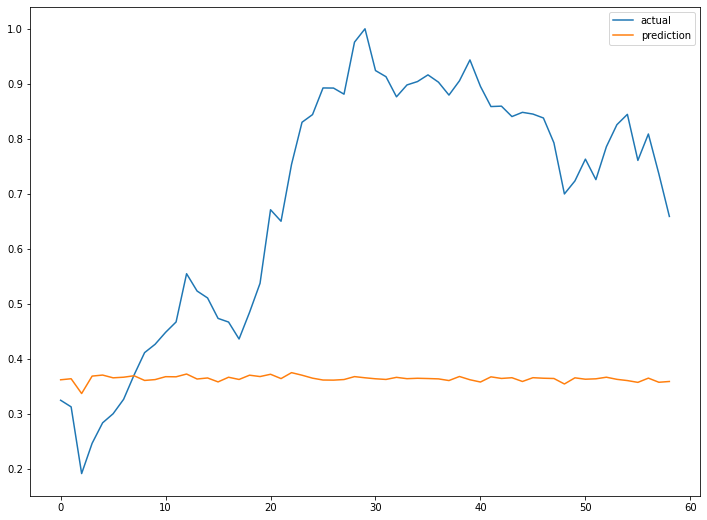

Metal의 test_data의 출력 크기 :  (59, 1)


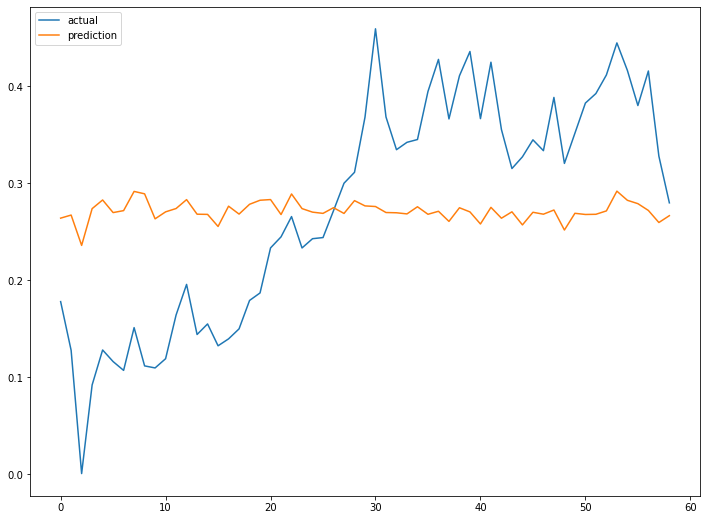

Machine의 test_data의 출력 크기 :  (59, 1)


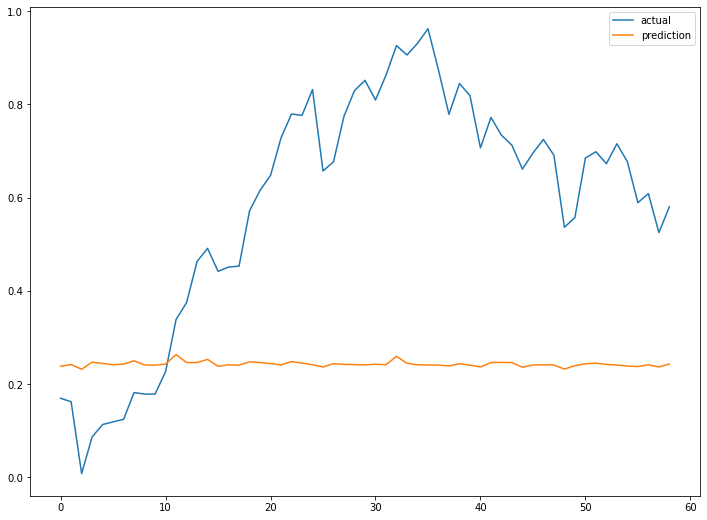

Electronic의 test_data의 출력 크기 :  (59, 1)


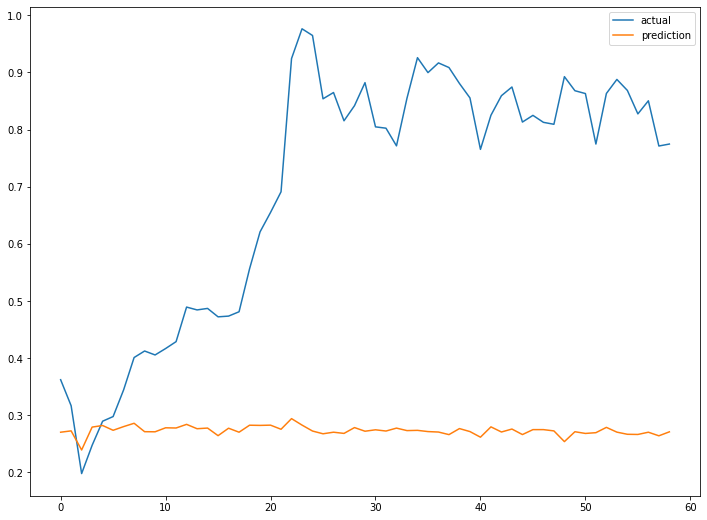

Construction의 test_data의 출력 크기 :  (59, 1)


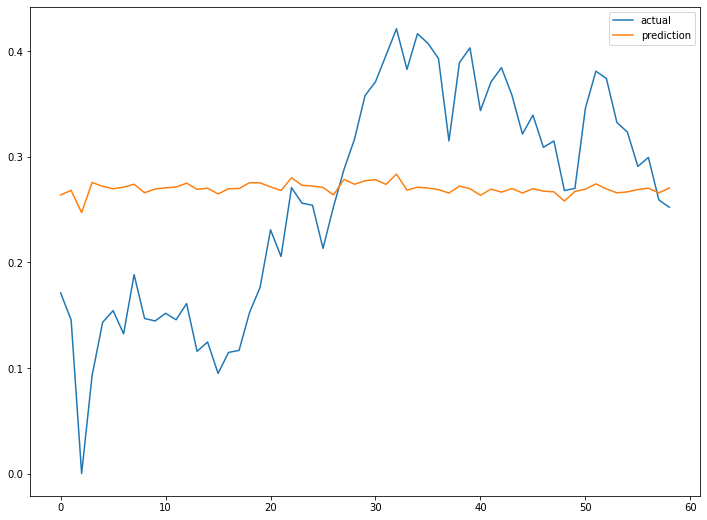

Transport의 test_data의 출력 크기 :  (59, 1)


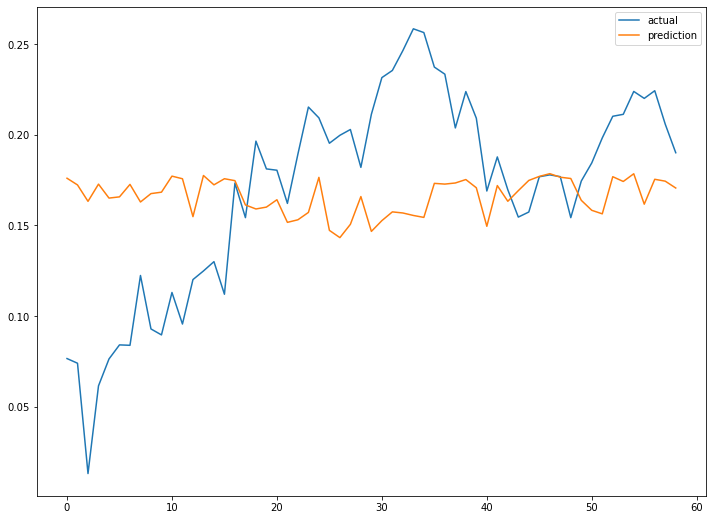

Distribution의 test_data의 출력 크기 :  (59, 1)


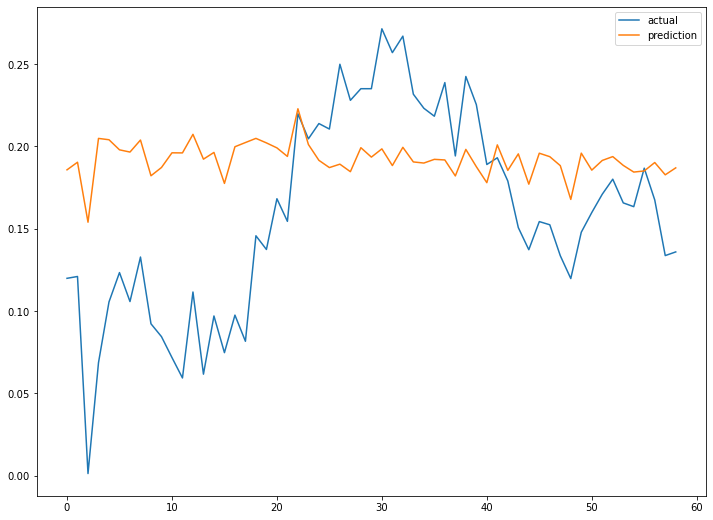

Power의 test_data의 출력 크기 :  (59, 1)


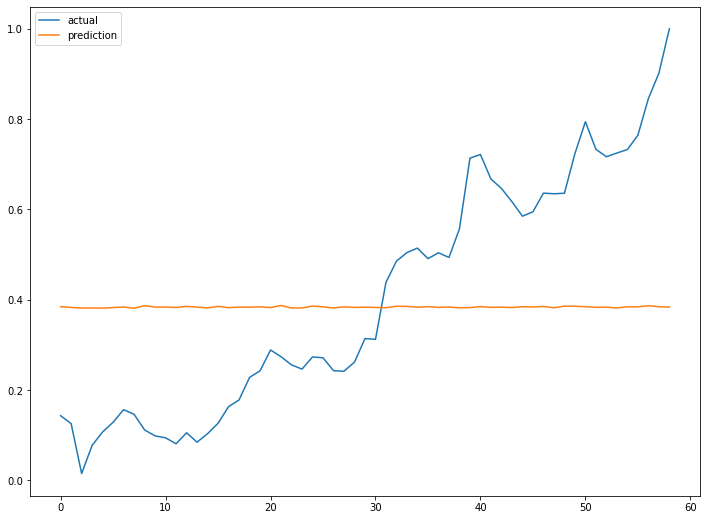

Tele의 test_data의 출력 크기 :  (59, 1)


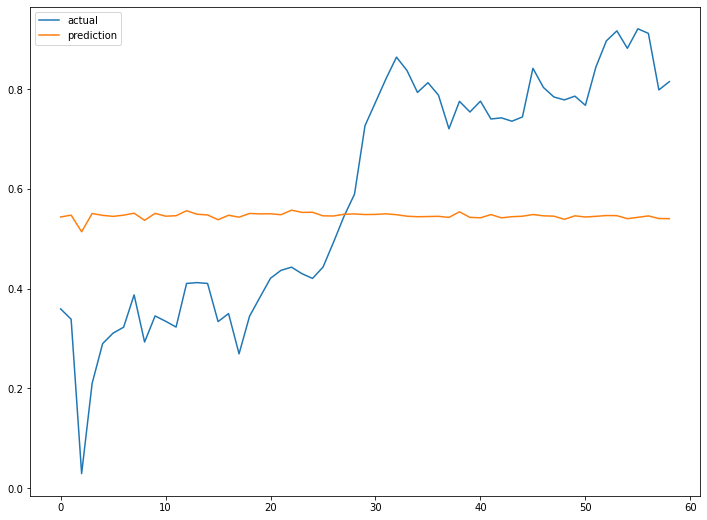

Finance의 test_data의 출력 크기 :  (59, 1)


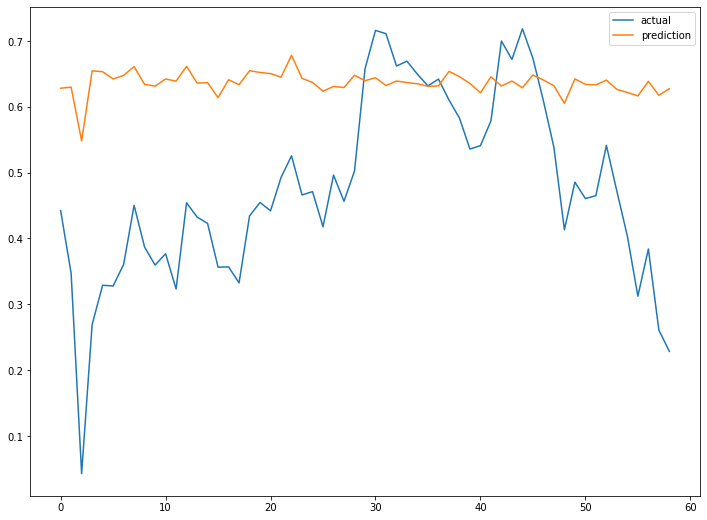

Brokerage의 test_data의 출력 크기 :  (59, 1)


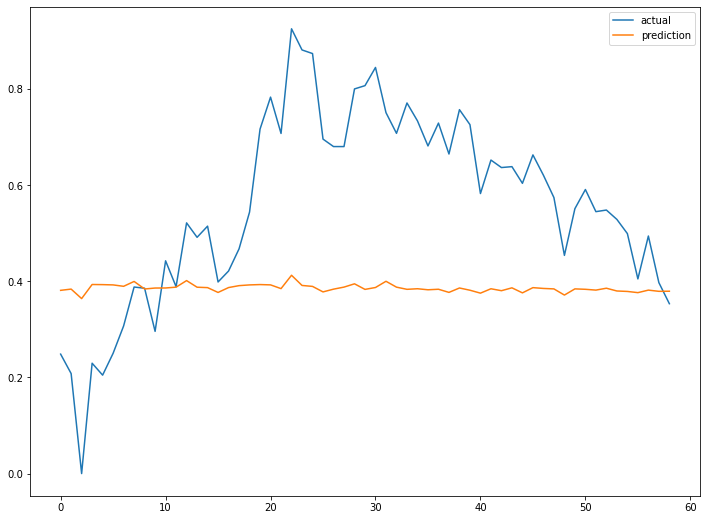

Insurer의 test_data의 출력 크기 :  (59, 1)


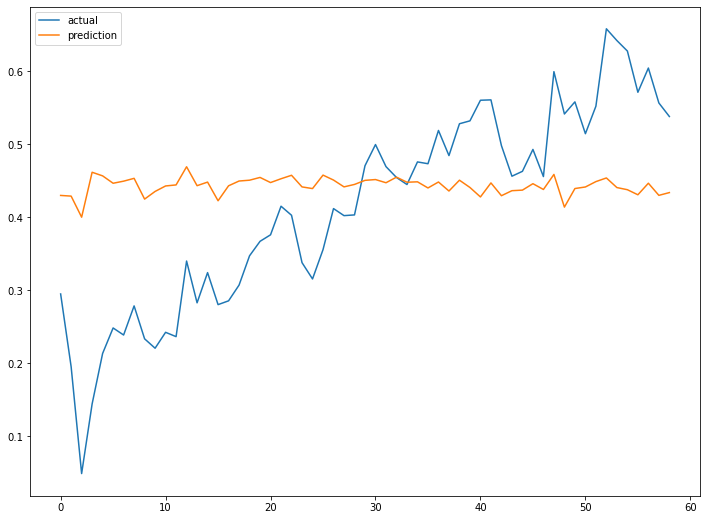

Service의 test_data의 출력 크기 :  (59, 1)


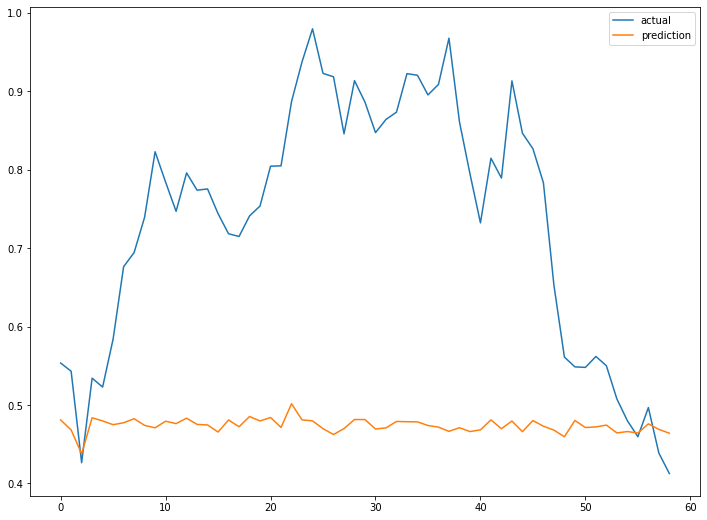

Manufacturer의 test_data의 출력 크기 :  (59, 1)


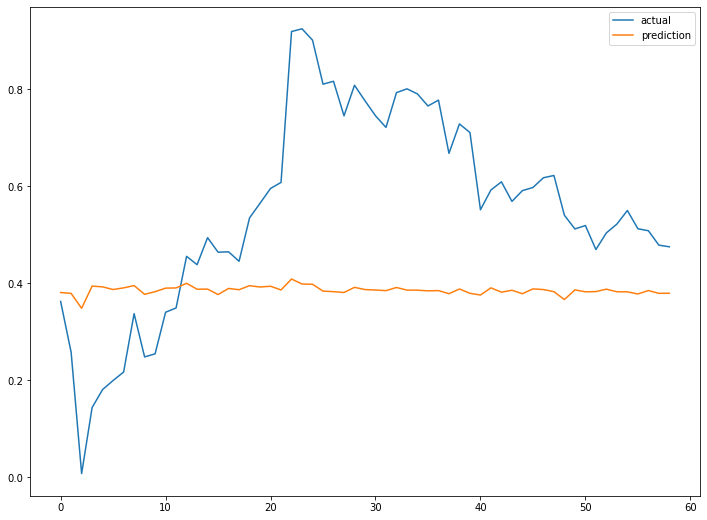

In [18]:
for sector_name, model in model_dic.items():
    pred = model.predict(tf_dataset_test_dic[sector_name])
    print(f'{sector_name}의 test_data의 출력 크기 : ' ,pred.shape)
    plt.figure(figsize=(12, 9))
    plt.plot(np.asarray(y_test_dic[sector_name])[10::10], label='actual')
    plt.plot(pred, label='prediction')
    #plt.xticks(test_dic[sector_name].index)
    plt.legend()
    plt.show()
          
          
    

## ex) Food 예측

In [1]:
# 오늘자 포함 6일치 예측값
ex_l = []
for i in range(6):
    ex = tf.constant(np.expand_dims(np.array(X_test_dic['Food'].tail(10+i)[:10]),axis=0))
    model = model_dic['Food']
    ex_l.append(float(model.predict(ex)))
ex_l

NameError: name 'tf' is not defined

In [ ]:
pred_l = []
for i in range(6):
    data = tf.constant(np.expand_dims(np.array(X_test_dic['Food'].tail(10+i)[:10]),axis=0))
    model = model_dic['Food']
    pred_l.append(float(model.predict(data)))
pre = sum(pred_l[1:])/5
if pred_l[0]>pre:
    print('Food 업종은 상향을 예상합니다.')
elif pred_l[0]<pre:
    print('Food 업종은 하향을 예상합니다.')

## 전 업종 예측

In [ ]:
for sector_name, model in model_dic.items():
    pred_l = []
    for i in range(6):
        data = tf.constant(np.expand_dims(np.array(X_test_dic[sector_name].tail(10+i)[:10]),axis=0))
        pred_l.append(float(model.predict(data)))
    pre = sum(pred_l[1:])/5
    if pred_l[0]>pre:
        print(f'{sector_name} 업종은 상향을 예상합니다.')
    elif pred_l[0]<pre:
        print(f'{sector_name} 업종은 하향을 예상합니다.')